In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = MNIST(root='data', train=True, transform=transform, download=True)
test_data = MNIST(root='data', train=False, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:06<00:00, 1.46MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 46.2kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 707kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.35MB/s]


In [6]:
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
model = SimpleNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        # images = images.view(images.size(0), -1).to(device)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() 

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Avg Loss: {avg_loss:.4f}")    

Epoch [1/3] - Avg Loss: 0.3406
Epoch [2/3] - Avg Loss: 0.0901
Epoch [3/3] - Avg Loss: 0.0621


In [10]:
model.eval()
correct = 0
total = 0

In [11]:

with torch.no_grad():
    for images, labels in test_loader:
        # images = images.view(images.size(0), -1).to(device)
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predictions = outputs.argmax(dim=1)

        total += labels.size(0)
        correct += (predictions == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total} %')



Accuracy of the model on the test images: 98.02 %


In [14]:
torch.save(model.state_dict(), 'digit_classifier_cnn.pth')
print('Model saved to digit_classifier_cnn.pth')
# import os
# print(os.getcwd())
# from google.colab import files
# files.download("digit_classifier_cnn.pth")
# print('Model downloaded')


Model saved to digit_classifier_cnn.pth


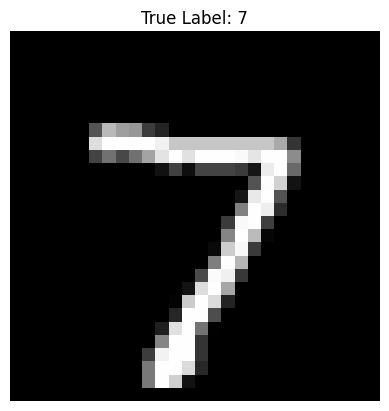

Index: 0
True Label: 7
Predicted Label: 7


In [15]:
index = 0
image, true_label = test_data[index]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'True Label: {true_label}')
plt.axis('off')
plt.show()

image = image.unsqueeze(0).to(device)  # shape: (1, 1, 28, 28)
# image_flat = image.view(1, -1).to(device)

with torch.no_grad():
    output = model(image)
    predicted_label = output.argmax(dim=1).item()


print(f'Index: {index}')
print(f'True Label: {true_label}')
print(f'Predicted Label: {predicted_label}')

In [16]:
import random
n = 1000
cnt = 0
for _ in range(n):
    index = random.randint(0, len(test_data)-1)
    image, true_label = test_data[index]

    # plt.imshow(image.squeeze(), cmap='gray')
    # plt.title(f'True Label: {true_label}')
    # plt.axis('off')
    # plt.show()

    image = image.unsqueeze(0).to(device)  # shape: (1, 1, 28, 28)

    with torch.no_grad():
        output = model(image)
        predicted_label = output.argmax(dim=1).item()

    if true_label == predicted_label:
        cnt += 1

    # print('---')
    # print(f'Index: {index}')
    # print(f'True Label: {true_label}')
    # print(f'Predicted Label: {predicted_label}')
print(f'Correct Predictions: {cnt} out of {n}')
print(f'Incorrect Predictions: {n - cnt} out of {n}')
print(f'Accuracy over {n} random samples: {100 * cnt / n} %')

Correct Predictions: 981 out of 1000
Incorrect Predictions: 19 out of 1000
Accuracy over 1000 random samples: 98.1 %
